# Classification
This is the code that will be used for classifying the MRIs into high-grade and low-grade gliomas. The dataset that we have used is the BraTS 2018 dataset. We will be working with 3D `numpy` arrays and using feature extraction to inform our model. We will also be comparing the efficiency of three different models: a support vector classifier, a random forest classifier, and a neural network. We will not only look at the accuracy score, but also the sensitivity, specificity, area under the curve, classification error rate, false positive rate, and precision.

We will first add the import statements we need.

In [2]:
import SimpleITK as sitk
import numpy as np
import nibabel as nib

We will first load all of the Numpy arrays we got from `segmentation.ipynb`.

In [3]:
filePath = '/Users/kaitlinylim/Documents/tumorproj/predictions/preds.txt'
preds = open(filePath, 'r')
path_all = preds.read().splitlines()
preds.close()

## Feature Extraction
For our Support Vector Classifier, we will be extracting statistical features that detail certain physical characteristics of the tumor, such as the volume, surface area, and "roughness."


In [4]:
import os
import pandas as pd
import numpy as np
import logging
from radiomics import featureextractor
import radiomics

We now need to configure the settings of the `RadiomicsFeatureExtractor`, which will extract the features that we need from the Numpy arrays.

In [5]:
settings = {}
settings['binWidth'] = 25
settings['resampledPixelSpacing'] = None
settings['interpolator'] = 'sitkBSpline'
settings['verbose'] = True

extractor = featureextractor.RadiomicsFeaturesExtractor(**settings)
extractor.enableFeatureClassByName('glcm')

We will be extracting the following features:


In [6]:
patient_id = []
elongation = []
flatness = []
majAL = []
minAL = []
threedimdiam = []
spher = []
surfArea = []
energ = []
entrop = []
kurt = []
mean = []
skew = []
cont = []
correl = []
idm = []
coarse = []
complexity = []
strength = []
y_labels = []

Now we will begin the feature extraction process.

In [ ]:
print("starting feature extraction")

for path in path_all:
    base = os.path.basename(path)
    img = nib.load('/Users/kaitlinylim/Documents/tumorproj/images/BraTS_2018_Training/{0}/{0}_t1.nii.gz'.format(base))
    img_npy = np.array(img.dataobj)
    mask_npy = np.load('/Users/kaitlinylim/Documents/tumorproj/predictions/{}.npy'.format(base))
    
    grade = os.path.split(path)[0]
    if grade == 'HGG':
        y_labels.append(1)
    else:
        y_labels.append(-1)
    
    mask_npy = np.transpose(mask_npy, (2, 1, 0))
    
    imageName = sitk.GetImageFromArray(img_npy)
    maskName = sitk.GetImageFromArray(mask_npy)
    
    # print('calculating features...')
    featureVector = extractor.execute(imageName, maskName)
    # print('all features have been calculated!')
    
    patient_id.append(base)
    elongation.append(featureVector['original_shape_Elongation'])
    flatness.append(featureVector['original_shape_Flatness'])
    majAL.append(featureVector['original_shape_MajorAxisLength'])
    minAL.append(featureVector['original_shape_MinorAxisLength'])
    threedimdiam.append(featureVector['original_shape_Maximum3DDiameter'])
    spher.append(featureVector['original_shape_Sphericity'])
    surfArea.append(featureVector['original_shape_SurfaceArea'])
    energ.append(featureVector['original_firstorder_Energy'])
    entrop.append(featureVector['original_firstorder_Entropy'])
    kurt.append(featureVector['original_firstorder_Kurtosis'])
    mean.append(featureVector['original_firstorder_Mean'])
    skew.append(featureVector['original_firstorder_Skewness'])
    cont.append(featureVector['original_glcm_Contrast'])
    correl.append(featureVector['original_glcm_Correlation'])
    idm.append(featureVector['original_glcm_Idm'])
    coarse.append(featureVector['original_ngtdm_Coarseness'])
    complexity.append(featureVector['original_ngtdm_Complexity'])
    strength.append(featureVector['original_ngtdm_Strength'])

print("finished!")

Now that we have all the features that we have appended to lists, we will now create a dictionary.

In [8]:
raw_data = {
    'elongation':elongation,
    'flatness':flatness,
    'major_axis_length':majAL,
    'minor_axis_length':minAL,
    'max_3D_diameter':threedimdiam,
    'sphericity':spher,
    'surface_area':surfArea,
    'energy':energ,
    'entropy':entrop,
    'kurtosis':kurt,
    'mean':mean,
    'skewness':skew,
    'contrast':cont,
    'correlation':correl,
    'inverse_diff_moment':idm,
    'coarseness':coarse,
    'complexity':complexity,
    'strength':strength,
    'y_labels':y_labels
}

Now we will convert the dictionary to a Pandas dataframe.

In [9]:
# save to pandas dataframe
df = pd.DataFrame(raw_data, index = patient_id)
y = df[['y_labels']]
df = df.drop(['y_labels'], axis=1)
df.head()

,elongation,flatness,major_axis_length,minor_axis_length,max_3D_diameter,sphericity,surface_area,energy,entropy,kurtosis,mean,skewness,contrast,correlation,inverse_diff_moment,coarseness,complexity,strength
Brats18_TCIA02_321_1,0.410551,0.371859,117.771230,48.351075,143.965274,0.197382,11473.496567,7.958203e+08,2.264798,21.614341,269.130092,-3.139890,0.711491,0.776743,0.791853,0.001085,32.464908,0.138606
Brats18_TCIA06_247_1,0.719883,0.475119,79.351963,57.124130,143.265488,0.293210,5403.576769,9.220076e+08,3.856640,13.048728,356.674945,1.148875,3.761085,0.896587,0.626296,0.002845,1105.845091,9.242380
Brats18_TCIA02_274_1,0.631877,0.549677,104.563695,66.071396,154.983870,0.182704,22012.456549,2.769988e+09,2.511696,4.321459,333.474599,-0.845955,0.510800,0.859317,0.785737,0.000622,39.885279,0.109416
Brats18_TCIA03_265_1,0.659872,0.496086,59.223413,39.079901,136.425804,0.292943,11891.898372,9.972401e+08,2.102985,6.013888,222.749369,0.250013,0.393505,0.799241,0.841269,0.000692,46.353886,0.180415
Brats18_CBICA_ABO_1,0.805864,0.721765,60.137560,48.462701,139.552857,0.247074,21539.417092,2.561244e+09,2.757710,11.156899,258.873474,-0.950816,1.631505,0.757519,0.655941,0.000284,116.998761,0.075770


In order to improve the functionality of the model, we will be normalizing the data using the `preprocessing` module from `sklearn`.

In [10]:
from sklearn import preprocessing

x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_df = pd.DataFrame(x_scaled, index = patient_id)
normalized_df.columns = df.columns

In [11]:
normalized_df = pd.concat([normalized_df, y], axis = 1)
normalized_df.head()

,elongation,flatness,major_axis_length,minor_axis_length,max_3D_diameter,sphericity,surface_area,energy,entropy,kurtosis,mean,skewness,contrast,correlation,inverse_diff_moment,coarseness,complexity,strength,y_labels
Brats18_TCIA02_321_1,0.196263,0.313608,0.379507,0.080035,0.211280,0.107080,0.229644,0.000292,0.118215,0.510890,0.018854,0.211821,0.001936,0.498839,0.877329,0.111706,0.000089,0.002028,1
Brats18_TCIA06_247_1,0.659464,0.488738,0.172290,0.155769,0.205471,0.346666,0.081190,0.000343,0.373512,0.287493,0.031258,0.917063,0.014315,0.816580,0.658307,0.325124,0.003662,0.148578,1
Brats18_TCIA02_274_1,0.527682,0.615189,0.308271,0.233008,0.302740,0.070384,0.487398,0.001083,0.157812,0.059881,0.027971,0.589034,0.001121,0.717767,0.869238,0.055620,0.000114,0.001558,1
Brats18_TCIA03_265_1,0.569603,0.524298,0.063726,0.000000,0.148698,0.345998,0.239876,0.000373,0.092263,0.104020,0.012282,0.769255,0.000645,0.558488,0.942704,0.064052,0.000135,0.002701,1
Brats18_CBICA_ABO_1,0.788214,0.907053,0.068656,0.080998,0.174654,0.231320,0.475829,0.001000,0.197267,0.238153,0.017400,0.571791,0.005670,0.447870,0.697525,0.014651,0.000370,0.001017,1


Now we will shuffle the dataset.

In [12]:
from sklearn.utils import shuffle
shuffled = shuffle(normalized_df)
shuffled.head()

,elongation,flatness,major_axis_length,minor_axis_length,max_3D_diameter,sphericity,surface_area,energy,entropy,kurtosis,mean,skewness,contrast,correlation,inverse_diff_moment,coarseness,complexity,strength,y_labels
Brats18_TCIA04_343_1,1.000000,0.544877,0.336263,0.560165,0.280700,0.254252,0.000000,0.000000,0.147423,0.123950,0.012353,0.719605,0.004215,0.101555,0.829715,1.000000,0.000105,0.011921,1
Brats18_TCIA08_242_1,0.736630,0.444120,0.177752,0.197814,0.133784,0.128577,0.225938,0.001127,0.265999,0.080614,0.051794,0.582199,0.006410,0.693637,0.672952,0.131135,0.000557,0.008946,1
Brats18_TCIA06_372_1,0.418755,0.390939,0.268582,0.131827,0.398997,0.274278,0.265176,0.000833,0.189608,0.375019,0.027518,0.189266,0.005511,0.708103,0.855245,0.075585,0.000249,0.003632,1
Brats18_TCIA13_634_1,0.262250,0.300576,0.407103,0.144917,0.312797,0.244744,0.379861,0.019583,0.528824,0.114378,0.163678,1.000000,0.047831,0.871061,0.324893,0.059450,0.009656,0.028964,-1
Brats18_TCIA02_274_1,0.527682,0.615189,0.308271,0.233008,0.302740,0.070384,0.487398,0.001083,0.157812,0.059881,0.027971,0.589034,0.001121,0.717767,0.869238,0.055620,0.000114,0.001558,1


To visualize the data and have a brief overview of the different variables and their possible relationships with one another, we'll be using `sns.pairplot` to plot one feature against another.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(shuffled, hue = 'y_labels')
plt.show()

<Figure size 4817.24x4750 with 380 Axes>

We can also use a heat map to detect relationships between features.

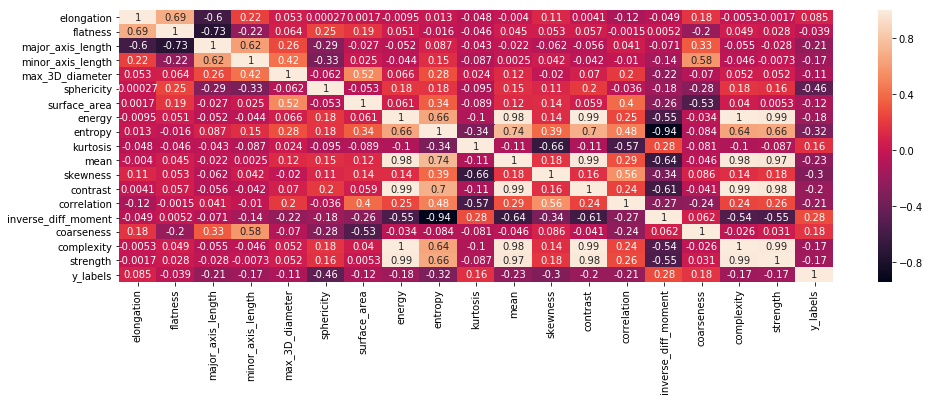

In [14]:
plt.figure(figsize = (16,5))
sns.heatmap(shuffled.corr(), annot = True)

Now that we have our preliminary graphical analysis finished, we can go on with splitting the data into training and testing, which will be 80% and 20%, respectively. Afterwards, we will continue with the fitting of different machine learning models.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(shuffled.loc[:, 'elongation':'strength'], np.ravel(shuffled[['y_labels']]),
                                                   test_size = 0.2, random_state = 42)

## Support Vector Classifier
We will begin with creating the support vector classifier model. The hyperparameters will be found using cross validation, and more specifically, `GridSearchCV`. We will begin with the necessary import statements.

In [45]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingClassifier

For the SVC, we will use the `GridSearchCV` method to find the proper hyperparameters for the support vector classifiers.

In [158]:
svc = SVC(probability = True)
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(svc, parameters, cv=5)

And now we will train the model, then fit on the testing data.

In [159]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [122]:
# fit on test data
clf.predict(X_test)
clf.score(X_test, y_test)

0.8

We will also be calculating the average of a few accuracy metrics, including the accuracy score. We will be using cross-validation to do so.

In [212]:
from sklearn.metrics import confusion_matrix

accuracy = []
class_error = []
sensitivity = []
specificity = []
false_pos = []
precision = []

cv = StratifiedKFold(n_splits = 5, shuffle = True)
X = shuffled.loc[:, 'elongation':'strength']
y = np.ravel(shuffled[['y_labels']])

for train, test in cv.split(X, y):
    X_tr, y_tr = X.values[train], y[train]
    X_te, y_te = X.values[test], y[test]
    
    clf.fit(X_tr, y_tr)
    clf.predict(X_te)
    
    accuracy.append(clf.score(X_te, y_te))
    
    confusion = confusion_matrix(y_te, clf.predict(X_te))
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    class_error.append((FP + FN) / float(TP + TN + FP + FN))
    sensitivity.append(TP / float(FN + TP))
    specificity.append(TN / (TN + FP))
    false_pos.append(FP / float(TN + FP))
    precision.append(TP / float(TP + FP))

print("average accuracy:", sum(accuracy) / len(accuracy))
print("average classification error:", sum(class_error) / len(class_error))
print("average sensitivity:", sum(sensitivity) / len(sensitivity))
print("average specificity:", sum(specificity) / len(specificity))
print("average false positive rate:", sum(false_pos) / len(false_pos))
print("average precision:", sum(precision) / len(precision))

average accuracy: 0.8121303258145363
average classification error: 0.1878696741854637
average sensitivity: 0.9469696969696969
average specificity: 0.625
average false positive rate: 0.375
average precision: 0.7886425339366516


We will also plot the ROC, or the receiver operating characteristic, curve and calculating the area under the curve. The closer the area is to 1, the better the model performs.

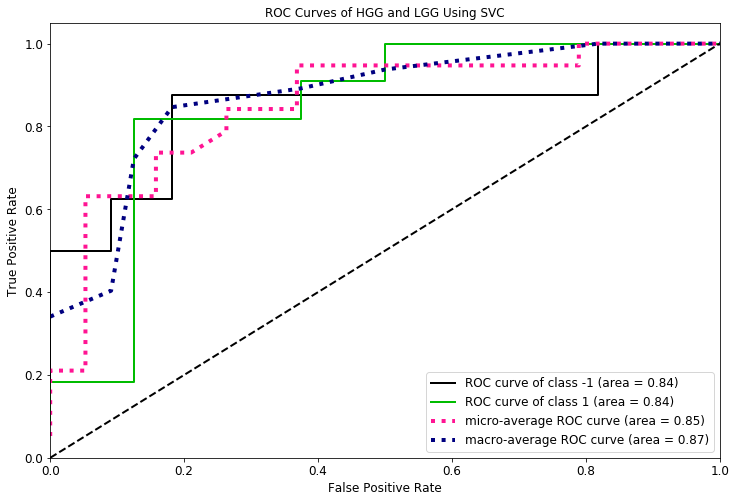

In [227]:
import scikitplot as skplt
skplt.metrics.plot_roc(y_test, clf.predict_proba(X_test), 
                       title="ROC Curves of HGG and LGG Using SVC", figsize = (12, 8), text_fontsize = 'large')

## Random Forest Classifier
Now we will try a Random Forest Classifier to try and classify the data.

In [131]:
from sklearn.ensemble import RandomForestClassifier

We will be using a `RandomizedSearchCV` to select the proper hyperparameters for the random forest classifier.

In [132]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

After we find the most optimal hyperparameters, we will fit the training data into the model.

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [134]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

Now we will fit the testing data to the model.

In [135]:
best_random = rf_random.best_estimator_
best_random.fit(X_test, y_test)
best_random.score(X_test, y_test)

1.0

As we did with the SVC, we will also try to calculate an average of the accuracy score, among other accuracy metrics.

In [215]:
from sklearn.metrics import confusion_matrix

accuracy = []
class_error = []
sensitivity = []
specificity = []
false_pos = []
precision = []

cv = StratifiedKFold(n_splits = 5, shuffle = True)
X = shuffled.loc[:, 'elongation':'strength']
y = np.ravel(shuffled[['y_labels']])

for train, test in cv.split(X, y):
    X_tr, y_tr = X.values[train], y[train]
    X_te, y_te = X.values[test], y[test]
    
    best_random.fit(X_tr, y_tr)
    best_random.predict(X_te)
    
    accuracy.append(clf.score(X_te, y_te))
    
    confusion = confusion_matrix(y_te, clf.predict(X_te))
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    class_error.append((FP + FN) / float(TP + TN + FP + FN))
    sensitivity.append(TP / float(FN + TP))
    specificity.append(TN / (TN + FP))
    false_pos.append(FP / float(TN + FP))
    precision.append(TP / float(TP + FP))

print("average accuracy:", sum(accuracy) / len(accuracy))
print("average classification error:", sum(class_error) / len(class_error))
print("average sensitivity:", sum(sensitivity) / len(sensitivity))
print("average specificity:", sum(specificity) / len(specificity))
print("average false positive rate:", sum(false_pos) / len(false_pos))
print("average precision:", sum(precision) / len(precision))

average accuracy: 0.830125313283208
average classification error: 0.16987468671679196
average sensitivity: 1.0
average specificity: 0.5972222222222222
average false positive rate: 0.4027777777777778
average precision: 0.7764145658263305


We will also plot the ROC curve and find the AUC value.

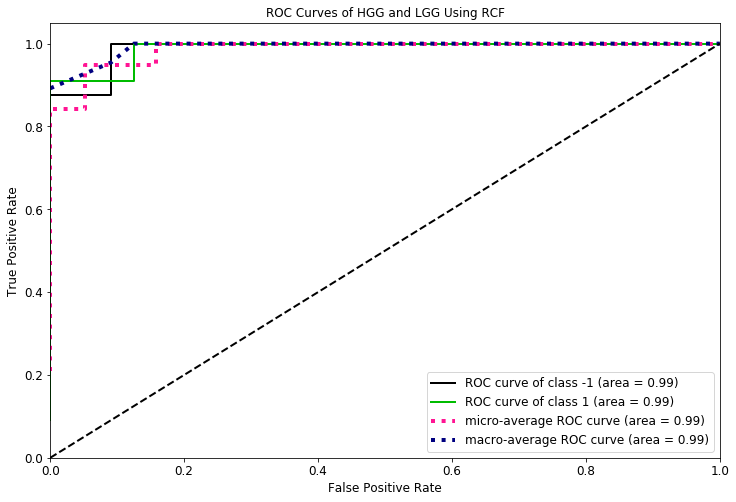

In [228]:
skplt.metrics.plot_roc(y_test, best_random.predict_proba(X_test), 
                       title="ROC Curves of HGG and LGG Using RCF", figsize = (12, 8), text_fontsize = 'large')

## Neural Networks
Lastly, we will use a neural network to try and classify the data. We will be using Keras with a Tensorflow backend.

In [16]:
from keras import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Now we will create the actual architecture of the neural network. It's a rather simple architecture: three hidden layers with thirty, forty, and thirty nodes.

In [56]:
# assuming that it's going to do its initial weights appropriately? might need to assign initial weights
# also, changing from -1 and 1 to 0 and 1
classifier = Sequential()
classifier.add(Dense(18, activation = 'relu',
              kernel_initializer = 'random_normal', input_dim = 18))
classifier.add(Dense(20, activation = 'relu',
              kernel_initializer = 'random_normal'))
classifier.add(Dense(10, activation = 'relu',
              kernel_initializer = 'random_normal'))
classifier.add(Dense(1, activation = 'sigmoid',
              kernel_initializer = 'random_normal'))

Now we will compile the neural network. We'll be using the cross-entropy loss function with the Adam optimizer.

In [57]:
from keras.optimizers import Adam
optimizer = Adam(lr = 0.001)
classifier.compile(optimizer, loss='binary_crossentropy', metrics =['accuracy'])

In [58]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

Now, we will fit the data to the training dataset.

In [ ]:
classifier.fit(X_train, y_train, batch_size=5, epochs=1000)

In [34]:
eval_model=classifier.evaluate(X_train, y_train)
eval_model

40/40 [==============================] - 0s 3ms/step


[0.03344989642500877, 1.0]

And now we will manipulate the predictions for further model evaluation.

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

accuracy = []
class_error = []
sensitivity = []
specificity = []
false_pos = []
precision = []

cv = StratifiedKFold(n_splits = 5, shuffle = True)
X = shuffled.loc[:, 'elongation':'strength']
y = np.ravel(shuffled[['y_labels']])
y[y == -1] = 0

for train, test in cv.split(X, y):
    X_tr, y_tr = X.values[train], y[train]
    X_te, y_te = X.values[test], y[test]
    
    preds_nn = classifier.predict(X_te)
    preds_nn = (preds_nn < 0.5).astype(np.int)
    # print(preds_nn)
    
    accuracy.append(accuracy_score(y_te, preds_nn))
    # print(y_te, preds_nn, accuracy_score(y_te, preds_nn))
    
    confusion = confusion_matrix(y_te, preds_nn)
    # print(confusion)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    class_error.append((FP + FN) / float(TP + TN + FP + FN))
    sensitivity.append(TP / float(FN + TP))
    specificity.append(TN / (TN + FP))
    false_pos.append(FP / float(TN + FP))
    precision.append(TP / float(TP + FP))

print("average accuracy:", sum(accuracy) / len(accuracy))
print("average classification error:", sum(class_error) / len(class_error))
print("average sensitivity:", sum(sensitivity) / len(sensitivity))
print("average specificity:", sum(specificity) / len(specificity))
print("average false positive rate:", sum(false_pos) / len(false_pos))
print("average precision:", sum(precision) / len(precision))

average accuracy: 0.05636363636363637
average classification error: 0.9436363636363637
average sensitivity: 0.03333333333333333
average specificity: 0.09
average false positive rate: 0.9099999999999999
average precision: 0.04


Now that we have finished evaluating all of our models, we will fit all of the metrics into one bar graph for easy comparison. I've elected not to add the neural network because there's something really wonky going on during training. Thus, I'll only add the calculated metrics from the support vector classifier and the random forest classifier.

## Conclusion

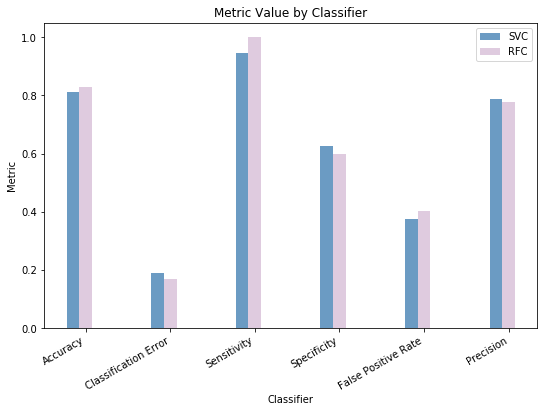

In [274]:
# data to plot
n_groups = 6
vals_svc = (0.8121, 0.1879, 0.9470, 0.625, 0.375, 0.7886)
vals_rfc = (0.8301, 0.1699, 1.0, 0.5972, 0.4028, 0.7764)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, vals_svc, bar_width,
alpha=opacity,
color='#4682b4',
label='SVC')

rects2 = plt.bar(index + bar_width, vals_rfc, bar_width,
alpha=opacity,
color='#d8bfd8',
label='RFC')

plt.xlabel('Classifier')
plt.ylabel('Metric')
plt.title('Metric Value by Classifier')
plt.xticks(index + bar_width, ('Accuracy', 'Classification Error',
                               'Sensitivity', 'Specificity',
                              'False Positive Rate', 'Precision'))
plt.legend()
 
plt.tight_layout()
fig.autofmt_xdate()
fig.set_size_inches(8, 6)
plt.show()